In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
import seaborn as sns
import pickle


2022-09-06 17:41:10.226407: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-06 17:41:10.230691: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lepton/.pyenv/versions/3.8.12/envs/Anaemia_Classification/lib/python3.8/site-packages/cv2/../../lib64:
2022-09-06 17:41:10.230702: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
with open('/home/lepton/Downloads/Anaemia/Anaemia/pictures_array.npy', 'rb') as f:
    pics_all = np.load(f)
with open('/home/lepton/Downloads/Anaemia/Anaemia/labels_array.npy', 'rb') as f:
    labels_all = np.load(f)

In [4]:
train_set = pics_all[0:1500]
test_set = pics_all[1200: 1800]
train_labels = labels_all[0:1500]
test_labels = labels_all[1200: 1800]

# print(len(train_set))
# print(len(train_labels))
# print(len(test_set))
# print(len(test_labels))

In [5]:
x_train,y_train,x_test,y_test = train_set,train_labels, test_set, test_labels
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [6]:
activation = 'sigmoid'
feature_ext = Sequential()
feature_ext.add(Conv2D(200,3,activation = activation,padding = "same", input_shape=(224, 224, 3)))

feature_ext.add(Conv2D(150, kernel_size=(3, 3), activation=activation, padding = 'same'))
#   

feature_ext.add(Conv2D(100, kernel_size=(3), activation=activation)) # kernel_size = 3 <==> (3, 3)
#feature_ext.add(layers.MaxPool2D(pool_size=(2,2))) 

feature_ext.add(Conv2D(50, kernel_size=(3), activation=activation)) #kernel_size = 3 <==> (3, 3)
#feature_ext.add(layers.MaxPool2D(pool_size=(2,2))) 

feature_ext.add(Conv2D(20, kernel_size=(3), activation=activation)) # kernel_size = 3 <==> (3, 3)
#feature_ext.add(layers.MaxPool2D(pool_size=(2,2))) 

feature_ext.add(Flatten())

In [7]:
x = feature_ext.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(1, activation = "sigmoid")(x)

# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=feature_ext.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop',loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
print(cnn_model.summary()) 


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 200)     5600      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 150)     270150    
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 100)     135100    
                                                                 
 conv2d_3 (Conv2D)           (None, 220, 220, 50)      45050     
                                                                 
 conv2d_4 (Conv2D)           (None, 218, 218, 20)      9020      
                                                                 
 flatten (Flatten)           (None, 950480)            0     

In [8]:
#history = cnn_model.fit(x_train, y_train, epochs=50, validation_data = (x_test, y_test))

In [9]:
x_for_RF = feature_ext.predict(x_train)

47/47 [==============================] - 456s 10s/step


In [10]:
x_for_RF.shape

(1500, 950480)

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=50,random_state=42)
model.fit(x_for_RF,y_train)


RandomForestClassifier(n_estimators=50, random_state=42)

In [12]:

x_test_feature = feature_ext.predict(x_test)

19/19 [==============================] - 154s 8s/step


In [13]:
x_test_feature.shape

(600, 950480)

1/1 [==============================] - 0s 277ms/step
The predicted label for this image is:  0
The actual label for this image is:  0


(224, 224, 3)

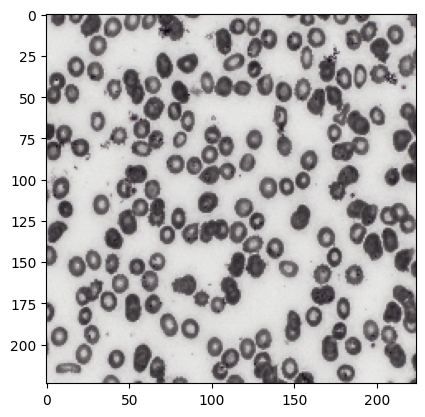

In [14]:
n=80#Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_ext.predict(input_img)
prediction_RF = model.predict(input_img_features)[0] 
#prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The predicted label for this image is: ", prediction_RF)
#print("The actual label for this image is: ", test_labels[n])
img.shape

In [15]:
prediction_RF = model.predict(x_test_feature)


In [16]:
from sklearn import metrics

print("Accuracy = ", metrics.accuracy_score(test_labels,prediction_RF))

Accuracy =  0.72


In [17]:
predictions = model.predict_proba(x_test_feature)
predictions[0]


array([0.94, 0.06])

In [19]:
filename = 'CNN-RF.sav'
pickle.dump(model, open(filename, 'wb'))